# <center> NYC Climate Change - Analysis of Temperature Changes </center>

This independent study analyzes daily temperature data for NYC over a 150+ year period (1901-Oct2022) to identify whether daily temperatures have been changing over time. This independent study has been motivated by the World Meteriological Organization's (WMO) briefing on the [Provisional State of the Global Climate in 2022](https://public.wmo.int/en/our-mandate/climate/wmo-statement-state-of-global-climate) and by this [NYTimes article](https://www.nytimes.com/interactive/2018/05/03/learning/08WGOITGraphLN.html). The NYTimes article is in turn based on [this paper](https://www.pnas.org/doi/epdf/10.1073/pnas.1205276109) by Dr. Hansen et al., and many of the research techniques within this project are guided by the methods used in the paper.

The data for this study has been obtained from the National Oceanic and Atmospheric Administration (NOAA) website [here](https://www.ncei.noaa.gov/cdo-web/). The dataset contains ~150 years worth of daily temperature data (Mar 1 1869 to Oct 27, 2022) from between 1-5 weather stations that NOAA classifies under the New York County. For each day, the data contains a minimum (TMIN) and maximum (TMAX) temperature readings; these readings have been averaged across the stations to generate one daily minimum and maximum reading. These daily temperatures are further averaged to generate a daily average temperature (TAVG). 

<!-- ![Outliers.png](attachment:Outliers.png) -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


dfraw = pd.read_csv("NOAAClimateDate3131289.csv", parse_dates = [2], index_col ="DATE").sort_index()
dfraw.dropna(axis = 0, how = "all", subset = ["TAVG","TMAX","TMIN"], inplace = True)   ##exclude rows were all readings are NAN


##generating a daily estimates for TMAX and TMIN by aggregating daily weather data from each station
df = dfraw.groupby("DATE").agg({"TMAX":np.nanmean, "TMIN":np.nanmean})
df["TAVG"] =  np.nanmean(df[["TMAX","TMIN"]], axis = 1).round(2)


##other data transformations
df = df.apply(lambda x: (x-32)*5/9).round(2).reset_index()       ##Faehrenheit to Celsius
df["MM-DD"] = df["DATE"].apply(lambda x: x.strftime("%m-%d"))
df["YYYY"] = df["DATE"].apply(lambda x:x.year)

df.head(2)

,DATE,TMAX,TMIN,TAVG,MM-DD,YYYY
0,1869-03-01,-3.33,-15.56,-9.44,03-01,1869
1,1869-03-02,2.22,-7.22,-2.50,03-02,1869


### <center> Comparison Period vs Baseline Period - Analysis of Daily Temperature Differences</center>

In order to analyze temperature changes, daily observed temperatures are compared to a baseline daily temperature. As explained [here](https://www.ncei.noaa.gov/access/monitoring/dyk/anomalies-vs-temperature), generally, a 30year or longer period would suffice as the "base period" as it is sufficiently long for meaningful statistical analysis. 

For this study, a ~30year "base period" has been choose from from 1869 to 1900<sup>1</sup>. This is close to the 1850-1900 pre-industrial baseline used in the Paris Agreemment Assessment report, per [here](https://public.wmo.int/en/our-mandate/climate/wmo-statement-state-of-global-climate). The baseline daily temperature is calculated by averaging the temperatures for that day for each year in the baseline period. For example, the base temperature for June 1 would be calculated as, the average of the June 1 temperatures seen for every year in the base period, i.e.,one for each year from 1869 through 1900 or 32 readings. This process is repeated for each day and in this way we will have 366 baseline temperatures, one for each day of the year.

The comparion dataset for this study is from 1901 through Oct 2022. The daily temperature for each day in the comparison period has been compared to the expected baseline temperature for that day. For example, the June 1 2022 average temperature (TAVG) is compared to the June 1 baseline average temperature (Base_Avg). If there has not been a material change in temperatures over the years, the expectation is that for a majority of days, this difference should be close to zero. The distribution of these differences is analyzed by decade<sup>2</sup> in Figure 1.

In [2]:
##BASELINE DATASET: 1869 - 1900

_ = df[df["DATE"]<"1901-01-01"] 
base = _.groupby("MM-DD").agg(Base_Avg = ("TAVG", np.mean),       ##avg. daily baseline temp.
                              Base_TMAX = ("TMAX",np.mean),       ##avg. baseline max and min temps.
                              Base_TMIN = ("TMIN",np.mean),
                              Base_RecordMax = ("TMAX",np.max),   ####record baseline max and min temps.(for outlier analysis)
                              Base_RecordMin = ("TMIN",np.min)).round(2).reset_index()


##COMPARISON DATASET: 1901- 2022

comp = df[df["DATE"]>="1901-01-01"]      

comp = comp.merge(base, left_on ="MM-DD", right_on ="MM-DD", how= "left")
comp["Diff"] = comp["TAVG"] - comp["Base_Avg"]            ##comparing daily temps. to the baseline daily temp.


##adding decade information
years = list(np.arange(1900,2023,10))
years.append(2022)
labels = []

for i in range(len(years)-1):
    labels.append(str(years[i]+1) + " to " + str(years[i+1]))

comp["Decade"] = pd.cut(comp["YYYY"],years, labels = labels) 
decades = [dec for dec in comp["Decade"].unique()]


comp[comp["DATE"] == "2022-06-01"][["DATE","TAVG","Base_Avg","Diff","Decade"]].head(2)

,DATE,TAVG,Base_Avg,Diff,Decade
44346,2022-06-01,18.89,19.76,-0.87,2021 to 2022


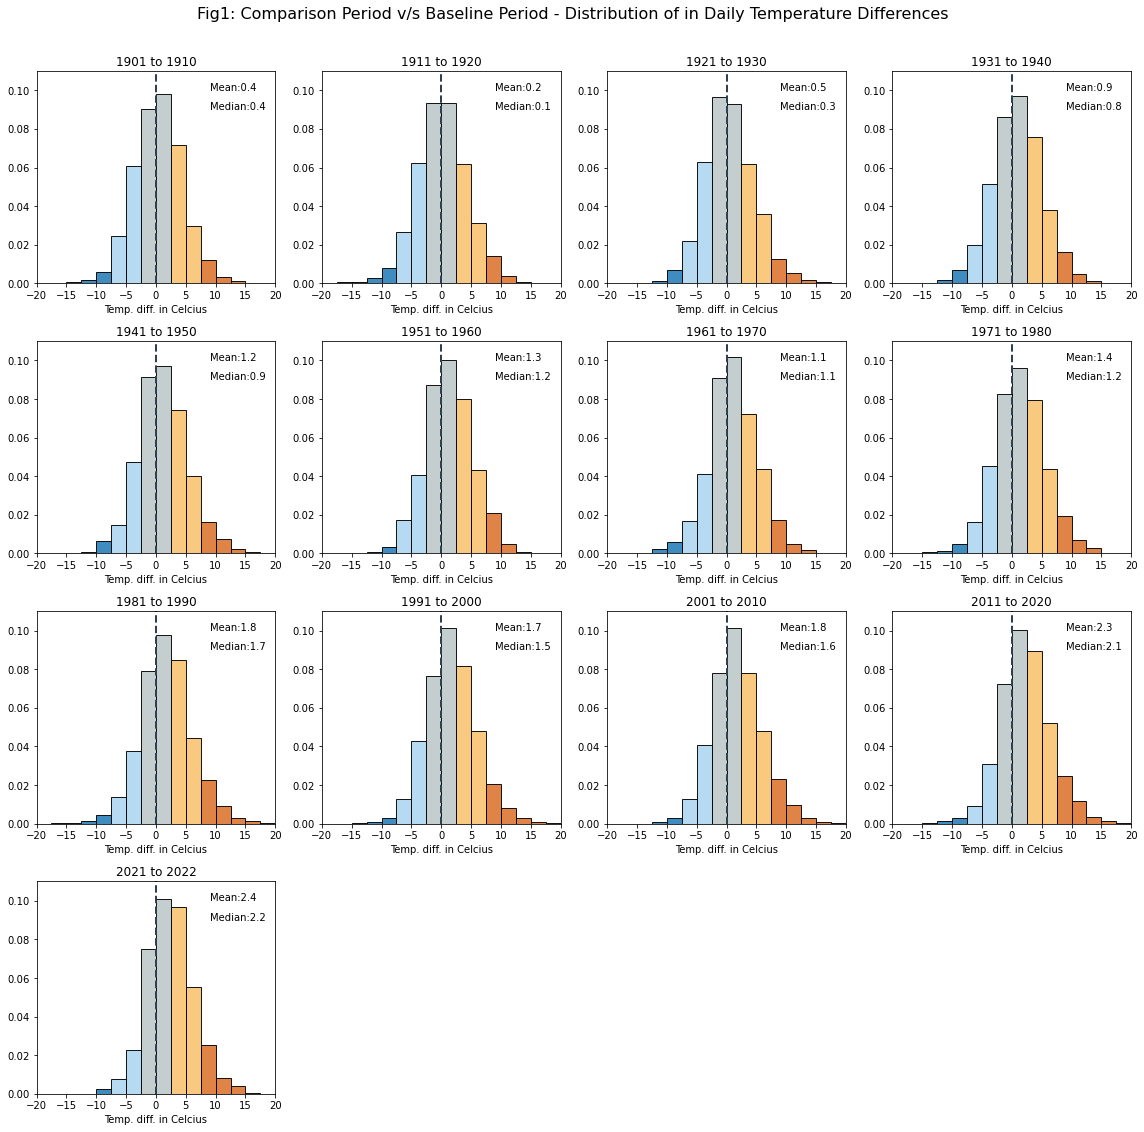

In [3]:
plt.figure(figsize = (16,16))
i=1
 
for decade in decades:
    
    _ = comp[comp["Decade"]==decade]    ##each suplot is one decade
    plt.subplot(4,4,i);

    n, bins, patches = plt.hist(_["Diff"], bins = np.arange(-20,23,2.5), density = True, alpha = 0.9, edgecolor = "black");
    
    for c, p in zip(bins, patches):
        if c >=-20 and c < -7.5: 
            plt.setp(p, 'facecolor', '#2980B9');
        elif c >= -7.5 and c < -2.5:
            plt.setp(p, 'facecolor', '#AED6F1');
        elif c >= -2.5 and c < 2.5:
            plt.setp(p, 'facecolor', '#BFC9CA');
        elif c >= 2.5 and c < 7.5:
            plt.setp(p, 'facecolor', '#F8C471');
        else: ##c>=10:
            plt.setp(p, 'facecolor', '#DC7633');
    
    plt.title(decade);
    
    plt.ylim(0,0.11);
    plt.gca().set_yticks(np.arange(0,0.11,0.02));
    
    plt.xlim(-20,20);
    plt.gca().set_xticks(np.arange(-20,21,5));
    plt.xlabel("Temp. diff. in Celcius", fontsize =10)
    
    plt.text(9,0.10, "Mean:"+str(round(_["Diff"].mean(),1)));
    plt.text(9,0.09, "Median:"+str(round(_["Diff"].median(),1)));
    plt.axvline(0, color = "#2E4053", ls = "--",lw = 2);

    i += 1

plt.suptitle("Fig1: Comparison Period v/s Baseline Period - Distribution of in Daily Temperature Differences\n\n", fontsize = 16);
plt.tight_layout()

plt.savefig('Histograms.png')

Each subplot within Figure 1 above, shows the <b>distribution of daily temperature differences</b> between the daily temperatures in that decade and the corresponding baseline temperatures for that day. Bars on the right of 0 indicate warmer daily temperature in that decade when compared to the baseline, i.e., positive differences. Similarly, the left would indicate cooler daily temperatures in that decade when compared to the baseline, i.e., negative differences. In this study, differences of +/-2.5 to +/- 7.5 against the baseline, are considered large differences (amber for warmer temperatures and light blue for cooler temperatures; and differences greater than +/- 7.5 against the baseline, are considered very large differences (red for warmer temperatures and dark blue for cooler temperatures)

The key observations:
* For each decade the daily temperature differences against baseline appear to be normally distributed. In the initial decades of the 20th century, this normal distribution appears to be centered at 0, i.e, mean 0 implying on average, no differences with baseline. But as we move through the decades, we see the normal distribution moving more to the right, i.e., more warmer temperatures or positive differences; and 2011 onwards, the distribution mean is closer to 2.5 (i.e., on average, temperatures are ~2.5 times higher than the baseline period). This movement can also been seen more clearly in Figure 2 below.
* Over the decades we can also see an increase in "extremely large" positive differences, implying significantly warmer temperatures. Further analysis on extreme temperatures is shown in Figure 3.

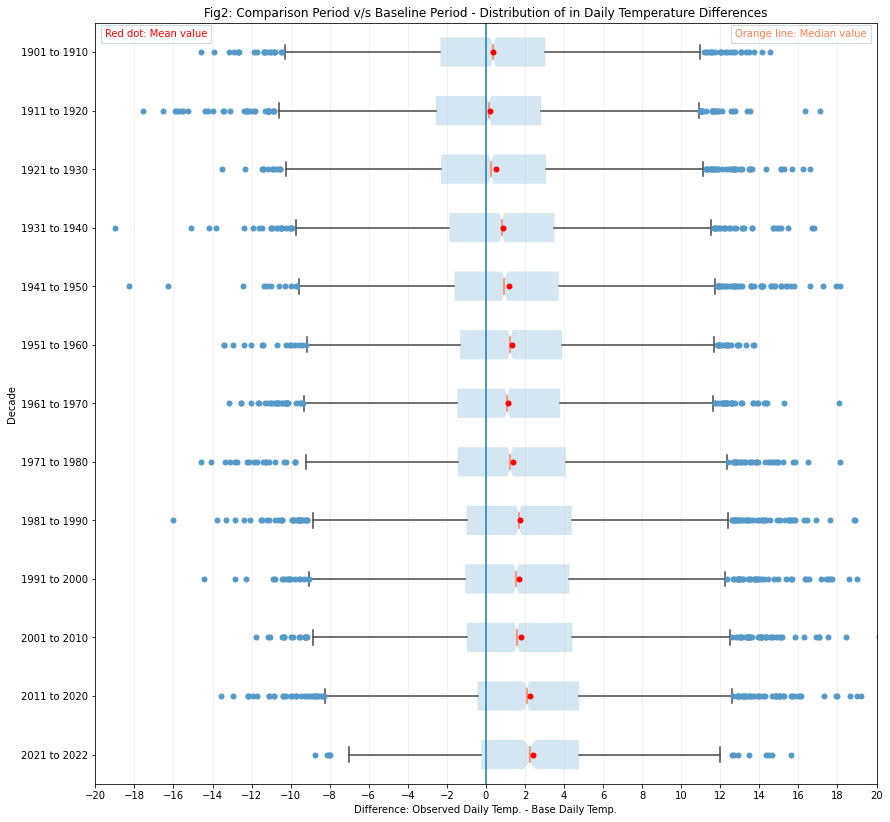

In [4]:
plt.figure(figsize = (14,14))
sns.boxplot(data= comp, x = "Diff", y = "Decade", width = 0.5, notch = True, showmeans = True,
            meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"none"}, #,"markersize":"10"},
            boxprops = {"facecolor" : "#D4E6F1", "edgecolor": "none"},
            flierprops = {"marker":"o", "markeredgecolor": "#5499C7","markerfacecolor" : "#5499C7"}, 
            medianprops={"color": "coral"}).set_title("Fig2: Comparison Period v/s Baseline Period - Distribution of in Daily Temperature Differences");
        
plt.xlabel("Difference: Observed Daily Temp. - Base Daily Temp.")
plt.grid(axis = "x", alpha = 0.2)

plt.text(19.5, -0.4, 'Orange line: Median value', color='coral',
        verticalalignment='top', horizontalalignment='right', 
         bbox={'edgecolor':'#AAB7B8', "facecolor": "#FDFEFE",'alpha':0.5,})

plt.text(-19.5, -0.4, 'Red dot: Mean value', color='red',
        verticalalignment='top', horizontalalignment='left', 
         bbox={'edgecolor':'#AAB7B8', "facecolor": "#FDFEFE",'alpha':0.5,})

plt.xlim(-20,20)
plt.gca().set_xticks(np.arange(-20,21,2))


plt.axvline(0)
plt.savefig("Boxplots.png")

### <center>Additional Analysis: Outliers</center>

Record max and min temperatures seen in the baseline period are used to create a range for comparison. The upper bound is the maximum temperature seen for a day during the baseline period (Base_RecordMax) and the lower bound is minimum temperature seen for that day during the baseline period (Base_RecordMin). Thus, this is the broadest range we can create based on the temperatures observed during the baseline period.

<b>Outliers</b> then, are any daily max/min temperatures outside of this range in the comparison period,i.e., where TMAX>Base_RecordMax or TMIN < Base_RecordTMin. For example, if the June 1 temperature for any year in a decade is greater than the record max baseline temperature for June 1, it would show as an outlier in Figure 2. <b>Extreme outliers</b>, are any daily max(min) temperatures that are more than 10C higher(lower) than the corresponding baseline record temperature for that day.

Through the decades, we see cooler temperature outliers decreasing compared to higher temperature outliers.

In [5]:
## OUTLIERS
## comparision daily temps that are outside of record baseline temps
comp["Warm_Outlier"] = comp.apply(lambda x:max(x["TMAX"] - x["Base_RecordMax"],0), axis = 1)
comp["Warm_Outlier"].replace(0,np.NaN, inplace = True)
comp["Warm_Outlier"] = comp["Warm_Outlier"] + comp["Base_RecordMax"]


comp["Cold_Outlier"] = comp.apply(lambda x:min(x["TMIN"] - x["Base_RecordMin"],0), axis = 1)
comp["Cold_Outlier"].replace(0,np.NaN, inplace = True)
comp["Cold_Outlier"] = comp["Cold_Outlier"] + comp["Base_RecordMin"]


## Extreme Outliers (only showing diff greater than 10)
comp["Xtr_Warm"] = comp.apply(lambda x:max(x["TMAX"] - x["Base_RecordMax"] - 10,0), axis = 1)
comp["Xtr_Warm"].replace(0,np.NaN, inplace = True)
comp["Xtr_Warm"] = comp["Xtr_Warm"] + comp["Base_RecordMax"] + 10


comp["Xtr_Cold"] = comp.apply(lambda x:min(x["TMIN"] - x["Base_RecordMin"] + 10,0), axis = 1)
comp["Xtr_Cold"].replace(0,np.NaN, inplace = True)
comp["Xtr_Cold"] = comp["Xtr_Cold"] + comp["Base_RecordMin"]-10

# comp[~comp["Warm_Outlier"].isnull()][["Decade","MM-DD", "Base_RecordMax","Base_RecordMin","TMAX","TMIN",
#                                   "Warm_Outlier","Cold_Outlier","Xtr_Warm","Xtr_Cold"]].head(2)

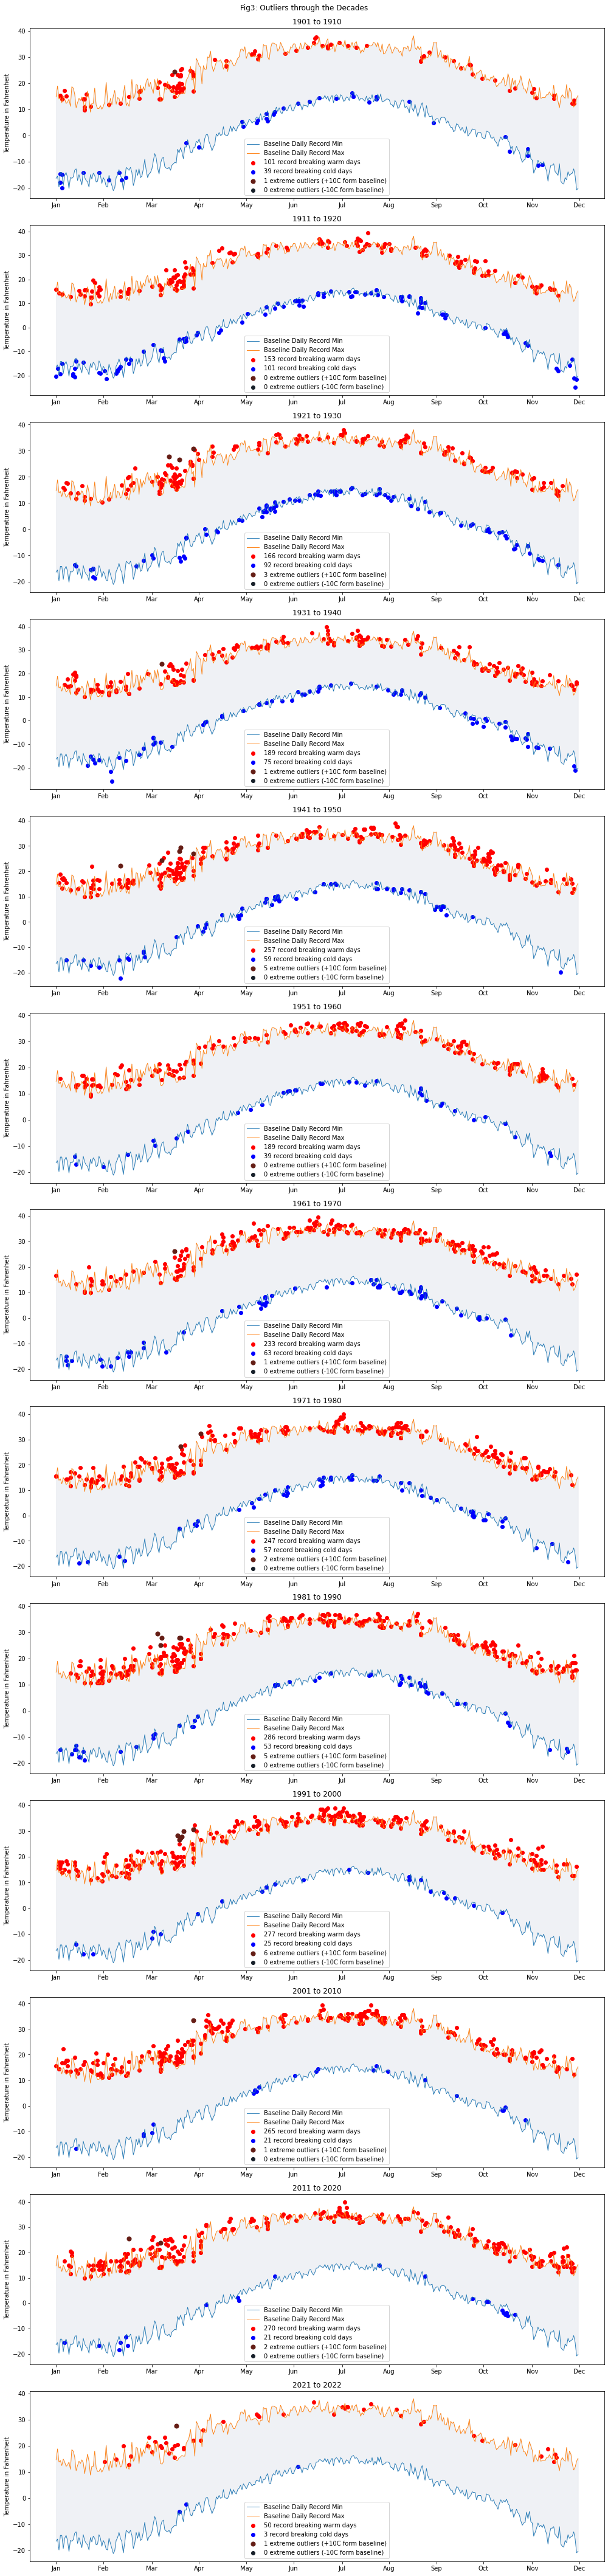

In [8]:
## OUTLIERS
## Baseline record max and record min form the bounds of our range (the widest range we can define). For our comparison 
## periods, we then plot daily temperatures that are significantly different from this range

plt.figure(figsize=(14,60))
i=1
    
##plotting the comparison dataset
for decade in decades:
    
    _ = comp[comp["Decade"] == decade]
    plt.subplot(13,1,i)

    ##Baseline record max and record min form the bounds of our range 
    plt.plot(base["Base_RecordMin"], lw = 0.9, label = "Baseline Daily Record Min")
    plt.plot(base["Base_RecordMax"], lw = 0.9, label = "Baseline Daily Record Max")
    plt.fill_between(base.index,base["Base_RecordMin"],base["Base_RecordMax"], color ="#d8dde6", alpha =0.4);

    ##outliers - record breaking temperatures from the comparison decades
    plt.scatter(_["MM-DD"],_["Warm_Outlier"], color ="red",label =str(_["Warm_Outlier"].count()) + " record breaking warm days");
    
    plt.scatter(_["MM-DD"],_["Cold_Outlier"], color ="blue",label =str(_["Cold_Outlier"].count()) + " record breaking cold days");
    
    
    ##extreme outliers - with differences greater than 10
    plt.scatter(_["MM-DD"],_["Xtr_Warm"], color ="#641E16", s = 50, label =str(_["Xtr_Warm"].count()) + " extreme outliers (+10C form baseline)");
    
    plt.scatter(_["MM-DD"],_["Xtr_Cold"], color ="#17202A",label =str(_["Xtr_Cold"].count()) + " extreme outliers (-10C form baseline)");
    
    
    plt.gca().set_xticks(np.linspace(0,366,12).round());
    plt.gca().set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]);
            
    plt.ylabel("Temperature in Fahrenheit");
    
    plt.legend(loc = "lower center");
    plt.title(decade)
    i += 1 

plt.suptitle("Fig3: Outliers through the Decades\n\n\n\n\n", fontsize = 12);
plt.tight_layout()            
plt.savefig("Outliers.png")

#### Reference Papers:

https://www.pnas.org/doi/epdf/10.1073/pnas.1205276109

https://www.climate-lab-book.ac.uk/2016/how-to-quantify-changes-in-climate-extremes-without-inducing-artefacts/

https://www.nytimes.com/interactive/2018/05/03/learning/08WGOITGraphLN.html

https://www.nytimes.com/interactive/2021/climate/extreme-summer-heat.html

https://public.wmo.int/en/our-mandate/climate/wmo-statement-state-of-global-climate


#### Footnotes:
1: Note, we do not have data for NYC prior to 1869 in NOAA

2: As expected, the last "decade" in the comparison dataset is not a true decade; we only have about ~1.5 years of data (Jan 2021 - Oct 2022)